# Week 9-1: Unsupervised Machine Learning

Van Pjotr en Sennen.

Deze week hebben we het over ongesuperviseerde machine learning. Dit is een vorm van machine learning waarbij we geen gelabelde data hebben. Dit betekent dat we geen data hebben waarbij we weten wat de juiste output is. In plaats daarvan gaan we op zoek naar patronen in de data. Dit kan bijvoorbeeld zijn dat we clusters van data vinden, of dat we de data kunnen reduceren naar een kleinere dimensie.

Maar deze keer gaan we clustering gebruiken, een techniek waarbij we data in groepen verdelen. Dit kan bijvoorbeeld handig zijn als we een dataset hebben met verschillende soorten bloemen, en we willen weten welke bloemen bij elkaar horen. Of als we een dataset hebben met verschillende soorten klanten, en we willen weten welke klanten bij elkaar horen.

PR9-1: Great Outdoors wil graag weten in welke segmenten verkoopafdelingen (‘sales_branches’) opgedeeld kan worden. Er bestaan al retailersegmenten (table ‘retailer_segment’), Great Outdoors wil dus óók segmenten creëren voor verkoopafdelingen:
- Pas waar nodig Dummy Encoding toe.
- Train het initiële clustermodel.
- Experimenteer met meerdere k’s door het berekenen van de inter- en intraclusterafstand.

Maar eerst een voorbeeld met de titanic.

## Bibliotheken importeren

In [69]:
import pandas as pd
import sqlite3
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter('ignore')

## Data inlezen en kolommen selecteren

In [70]:
df = pd.read_csv("data/titanic2.csv", sep = ';')
df = df.filter(regex='^(?!Unnamed).*$')
df

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Age
0,1,3,Braund; Mr. Owen Harris,male,1,0,A/5 21171,7.25,NaN,S,0,22
1,2,1,Cumings; Mrs. John Bradley (Florence Briggs Th...,female,1,0,PC 17599,712.833,C85,C,1,38
2,3,3,Heikkinen; Miss. Laina,female,0,0,STON/O2. 3101282,7.925,NaN,S,1,26
3,4,1,Futrelle; Mrs. Jacques Heath (Lily May Peel),female,1,0,113803,53.1,C123,S,1,35
4,5,3,Allen; Mr. William Henry,male,0,0,373450,8.05,NaN,S,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,Montvila; Rev. Juozas,male,0,0,211536,13,NaN,S,0,27
887,888,1,Graham; Miss. Margaret Edith,female,0,0,112053,30,B42,S,1,19
888,889,3,"Johnston; Miss. Catherine Helen ""Carrie""",female,1,2,W./C. 6607,23.45,NaN,S,0,15
889,890,1,Behr; Mr. Karl Howell,male,0,0,111369,30,C148,C,1,26


In [71]:
df = df.loc[:, ['Pclass', 'Sex', 'Age', 'Survived']]
df

,Pclass,Sex,Age,Survived
0,3,male,22,0
1,1,female,38,1
2,3,female,26,1
3,1,female,35,1
4,3,male,35,0
...,...,...,...,...
886,2,male,27,0
887,1,female,19,1
888,3,female,15,0
889,1,male,26,1


## One-hot encoding van onafhankelijke niet-numerieke variabelen

In [72]:
df['Pclass'] = df['Pclass'].astype(str)
df.dtypes

Pclass      object
Sex         object
Age          int64
Survived     int64
dtype: object

In [73]:
dummies_dataframe = pd.get_dummies(df.loc[:, ['Sex', 'Pclass']])
dummies_dataframe

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,False,True,False,False,True
1,True,False,True,False,False
2,True,False,False,False,True
3,True,False,True,False,False
4,False,True,False,False,True
...,...,...,...,...,...
886,False,True,False,True,False
887,True,False,True,False,False
888,True,False,False,False,True
889,False,True,True,False,False


In [74]:
df = pd.concat([df, dummies_dataframe], axis = 1)
df = df.drop(['Sex'], axis = 1)
df = df.loc[:, ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Age', 'Survived']]
df

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Survived
0,False,False,True,False,True,22,0
1,True,False,False,True,False,38,1
2,False,False,True,True,False,26,1
3,True,False,False,True,False,35,1
4,False,False,True,False,True,35,0
...,...,...,...,...,...,...,...
886,False,True,False,False,True,27,0
887,True,False,False,True,False,19,1
888,False,False,True,True,False,15,0
889,True,False,False,False,True,26,1


## Clusteringmodel bouwen met 2 dimensies

In [75]:
df_2d = df.loc[:, ['Age', 'Survived']]
df_2d

,Age,Survived
0,22,0
1,38,1
2,26,1
3,35,1
4,35,0
...,...,...
886,27,0
887,19,1
888,15,0
889,26,1


In [76]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit_predict(df_2d)

array([0, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2,
       0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 0, 0, 0, 2, 1, 0, 2, 2,
       2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 2,
       0, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0,
       1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1, 2,
       0, 1, 0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0,
       0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 1, 1, 0, 2,
       0, 2, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 0, 2, 2, 1, 0, 0, 2, 2, 2,
       2, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2,
       2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 0, 2, 2,
       2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 1, 1, 1,

In [77]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1
0,15.992481,0.379699
1,54.156682,0.354839
2,31.632353,0.401961


In [78]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})
    
kmeans_centra

,Age,Survived
0,15.992481,0.379699
1,54.156682,0.354839
2,31.632353,0.401961


In [79]:
for src_index, _ in df_2d.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df_2d.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df_2d.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df_2d

Afstand van bronindex 0 tot...
	Centrumindex 0:
		22 - 15.992481203007529 = 6.007518796992471
		0 - 0.3796992481203007 = -0.3796992481203007
	Totale euclidische som: 36.234453615240994
	Euclidische afstand: 6.0195060939616125
------------------------------------------------
	Centrumindex 1:
		22 - 54.156682027649765 = -32.156682027649765
		0 - 0.3548387096774193 = -0.3548387096774193
	Totale euclidische som: 1034.178109537259
	Euclidische afstand: 32.15863973393867
------------------------------------------------
	Centrumindex 2:
		22 - 31.63235294117647 = -9.632352941176471
		0 - 0.4019607843137254 = -0.4019607843137254
	Totale euclidische som: 92.94379565551712
	Euclidische afstand: 9.640736261070371
------------------------------------------------
{0: 6.0195060939616125, 1: 32.15863973393867, 2: 9.640736261070371}
0
Afstand van bronindex 1 tot...
	Centrumindex 0:
		38 - 15.992481203007529 = 22.00751879699247
		1 - 0.3796992481203007 = 0.6203007518796992
	Totale euclidische som: 484.

,Age,Survived,Centrum
0,22,0,0.0
1,38,1,2.0
2,26,1,2.0
3,35,1,2.0
4,35,0,2.0
...,...,...,...
886,27,0,2.0
887,19,1,0.0
888,15,0,0.0
889,26,1,2.0


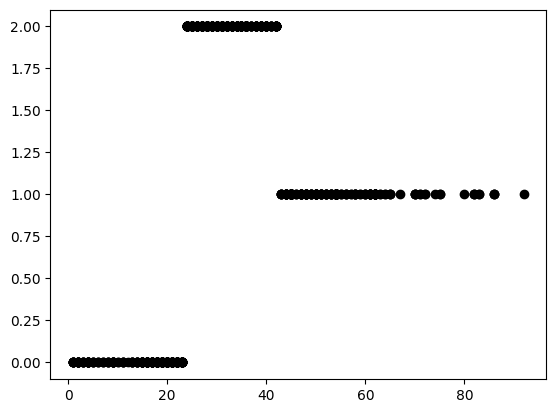

In [80]:
plt.scatter(df_2d['Age'], df_2d['Centrum'], color = 'k')
plt.show()

In [81]:
df_2d.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,266
1,217
2,408


## Clusteringmodel bouwen met meer dan 2 dimensies (alle kolommen uit de dataset)

### Centra berekenen

In [82]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([0, 1, 2, 2, 2, 2, 5, 4, 2, 0, 4, 5, 0, 1, 0, 5, 4, 2, 2, 2, 2, 2,
       0, 2, 4, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 4, 0, 1, 2, 5, 2, 0, 2, 4, 4, 0, 1, 1, 4, 1, 1,
       2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1, 1, 3, 2, 0, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 2, 0, 1, 2, 5, 0, 3, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 3, 2, 0, 4, 0, 3, 2, 2, 5, 4, 2, 0, 2, 1, 2, 0,
       1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 4, 2, 1, 5, 0, 5, 1,
       0, 5, 0, 2, 0, 0, 1, 1, 2, 0, 4, 4, 0, 1, 0, 2, 5, 4, 4, 0, 5, 0,
       0, 5, 2, 2, 0, 0, 4, 4, 4, 0, 0, 1, 1, 2, 2, 0, 0, 4, 1, 5, 0, 1,
       0, 0, 2, 0, 2, 1, 0, 4, 2, 2, 0, 1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 2,
       0, 2, 5, 1, 1, 0, 0, 0, 0, 2, 2, 2, 5, 4, 0, 2, 1, 4, 0, 2, 2, 2,
       2, 0, 2, 1, 0, 0, 2, 5, 2, 2, 5, 2, 1, 2, 2, 2, 2, 5, 2, 4, 5, 1,
       2, 2, 0, 0, 5, 2, 2, 0, 1, 2, 2, 5, 1, 2, 4, 2, 5, 2, 0, 0, 2, 2,
       2, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 4, 5, 5, 5,

In [83]:
df['Centrum'] = prediction_results
df

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Survived,Centrum
0,False,False,True,False,True,22,0,0
1,True,False,False,True,False,38,1,1
2,False,False,True,True,False,26,1,2
3,True,False,False,True,False,35,1,2
4,False,False,True,False,True,35,0,2
...,...,...,...,...,...,...,...,...
886,False,True,False,False,True,27,0,2
887,True,False,False,True,False,19,1,0
888,False,False,True,True,False,15,0,0
889,True,False,False,False,True,26,1,2


### De juiste centra toewijzen aan rijen uit de dataset

In [84]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,265
1,145
2,285
3,22
4,61
5,113


# De Sales Branches clusteren

Om de segmenten van de verkoopafdelingen te bepalen, gaan we de volgende stappen doorlopen:
- We kunnen de segmenten op basis van producten categorieën en het verkoop van die producten, bepalen welke segmenten we nodig zullen hebben voor onze verkoopafdeling.
- We pakken daarbij ook de branches van de retailers erbij, zodat we de segmenten van de verkoopafdelingen kunnen bepalen.
- Daarna zullen we gebaseerd op de omzet en kosten van de verkoopafdelingen, de segmenten bepalen.
- Waar we dan de gemixte data in een clustering model zullen stoppen en de segmenten bepalen.

Eerst gaan we de data inladen.

In [85]:
# Verbinding maken met de databases
conn_sales = sqlite3.connect('data/go_sales.sqlite')
conn_crm = sqlite3.connect('data/go_crm.sqlite')
conn_staff = sqlite3.connect('data/go_staff.sqlite')

# Gegevens ophalen uit de databases (Helaas verouderd)
sales_branch = pd.read_sql_query("SELECT * FROM sales_branch", conn_staff)
# country1 = pd.read_sql_query("SELECT * FROM country", conn_sales)
# country2 = pd.read_sql_query("SELECT * FROM country", conn_crm)
# territory = pd.read_sql_query("SELECT * FROM sales_territory", conn_crm)

# orders_header = pd.read_sql_query("SELECT * FROM order_header;", conn_sales)
# order_details = pd.read_sql_query("SELECT * FROM order_details;", conn_sales)

Hier gaan we de data van de great outdoors inlezen en bepaalde data dropen.

In [86]:
# (Helaas Verouderd)
# country = country1[['CURRENCY_NAME', 'LANGUAGE']]
# country = pd.concat([country2, country], axis = 1)
# sales_branch.drop('TRIAL633', axis=1, inplace=True)
# country.drop('TRIAL219', axis=1, inplace=True)
# territory.drop('TRIAL222', axis=1, inplace=True)
# orders_header.drop('TRIAL885', axis=1, inplace=True)
# order_details.drop('TRIAL879', axis=1, inplace=True)
sales_branch.drop('TRIAL633', axis=1, inplace=True)
sales_branch = sales_branch.drop(["ADDRESS1", "ADDRESS2", "POSTAL_ZONE"], axis=1)
sales_branch

,SALES_BRANCH_CODE,CITY,REGION,COUNTRY_CODE
0,13,Hamburg,None,2
1,14,München,None,2
2,15,Kista,None,10
3,17,Calgary,Alberta,4
4,18,Toronto,Ontario,4
5,19,Boston,Massachusetts,3
6,20,Seattle,Washington,3
7,21,Los Angeles,California,3
8,22,Miami,Florida,3
9,23,Lyon,None,1


We zorgen er nu voor dat we de sales_branches city en region gaan omzetten in dummies.

In [87]:
table = sales_branch[['CITY', 'REGION']]
df = pd.get_dummies(table)  # Dummy encoding

## Clusteringmodel bouwen met 2 dimensies

Eerst wordt een 2D-dataset gemaakt met de locaties van de verkoopfilialen.

Waar we ook dummy encoding toepassen.

In [88]:
table = pd.concat([sales_branch, df], axis=1)
table

,SALES_BRANCH_CODE,CITY,REGION,COUNTRY_CODE,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,...,REGION_Noord-Holland,REGION_Ontario,REGION_Osaka,REGION_SP,REGION_Taipei,REGION_Tokyo,REGION_VIC,REGION_Vizcaya,REGION_Washington,REGION_West Midlands
0,13,Hamburg,None,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,14,München,None,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,15,Kista,None,10,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,17,Calgary,Alberta,4,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,18,Toronto,Ontario,4,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
5,19,Boston,Massachusetts,3,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
6,20,Seattle,Washington,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7,21,Los Angeles,California,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,22,Miami,Florida,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,23,Lyon,None,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Een k-means clusteringmodel wordt geïnstantieerd met het gewenste aantal clusters (3 of 4 in het eerste geval, met een willenkeurigheid van 42) en toegepast op de 2D-dataset.

In [89]:
# Train het clustermodel
kmeans = KMeans(n_clusters=5, random_state=42)
prediction_results = kmeans.fit_predict(df)
prediction_results

kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df.columns[i]}'})
    
kmeans_centra

,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,CITY_Hamburg,CITY_Heverlee,CITY_Kista,CITY_Kuopio,...,REGION_Noord-Holland,REGION_Ontario,REGION_Osaka,REGION_SP,REGION_Taipei,REGION_Tokyo,REGION_VIC,REGION_Vizcaya,REGION_Washington,REGION_West Midlands
0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.387779e-17,0.041667,0.041667,0.041667,0.041667,1.387779e-17,0.041667,0.041667,0.041667,0.041667,...,1.387779e-17,1.387779e-17,0.041667,1.387779e-17,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
2,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


De centra van de clusters worden geëxtraheerd en weergegeven.
Voor elk punt in de dataset wordt de afstand tot elk clustercentrum berekend, en het punt wordt toegewezen aan het dichtstbijzijnde cluster.


In [90]:
for src_index, _ in df.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df

Afstand van bronindex 0 tot...
	Centrumindex 0:
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 1.0 = -1.0
		True - 0.0 = 1.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 1.0 = -1.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
		False - 0.0 = 0.0
	Totale euclidische som: 3.0
	Euclidische afstand: 1.7320508075688772
---------------------

,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,CITY_Hamburg,CITY_Heverlee,CITY_Kista,CITY_Kuopio,...,REGION_Ontario,REGION_Osaka,REGION_SP,REGION_Taipei,REGION_Tokyo,REGION_VIC,REGION_Vizcaya,REGION_Washington,REGION_West Midlands,Centrum
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1.0
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.0
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,1.0
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.0
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,2.0
5,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.0
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1.0
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.0
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.0
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.0


De resultaten worden gevisualiseerd door een scatterplot te maken van de kwantiteit versus de eenheidsprijs, waarbij de punten zijn gekleurd op basis van hun toegewezen cluster.

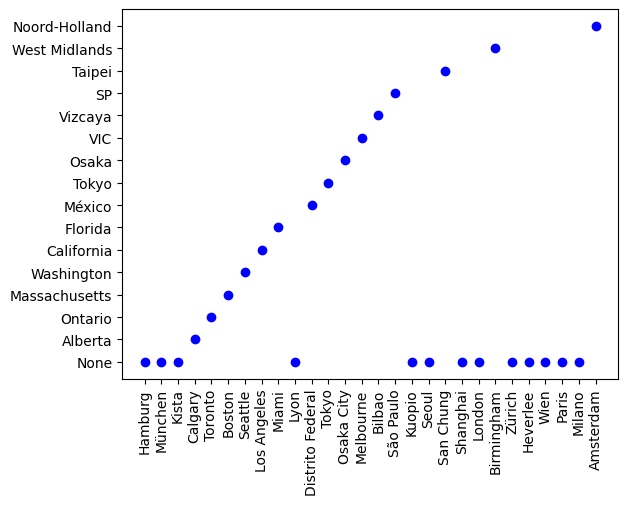

In [98]:
# (Helaas verouderd)
# plt.scatter(table['TERRITORY_NAME_EN'], table['CURRENCY_NAME'], c = prediction_results, cmap = 'rainbow')
# plt.show()
# Nu gaan we een bar weergeven, waar alle quantiteiten worden weergegeven per sales_branch
# Create a DataFrame with the branch names mapping
# branch_names = sales_branch[['SALES_BRANCH_CODE', 'CITY', 'REGION']]
# branch_names = branch_names.drop_duplicates()
# branch_names['CITY']

plt.scatter(table["CITY"].astype(str), table["REGION"].astype(str), color="blue")
plt.xticks(rotation=90)
plt.show()

De centra van de clusters worden geëxtraheerd en weergegeven.

In [99]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,1
1,17
2,3
3,1
4,1
5,1
6,1
7,1
8,1
9,1


## Clusteringmodel bouwen met meer dan 2 dimensies (alle kolommen uit de dataset)

Nu gaan we hetzelfde doen als hierboven, maar dan met alle kolommen uit de dataset. En misschien ook verder testen met verschillende k's.

In [100]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([3, 2, 2, 1, 1, 3, 4, 4, 3, 2, 0, 3, 3, 3, 1, 3, 2, 3, 3, 3, 2, 1,
       3, 3, 3, 3, 3, 4])

In [101]:
df['Centrum'] = prediction_results
df

,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,CITY_Hamburg,CITY_Heverlee,CITY_Kista,CITY_Kuopio,...,REGION_Ontario,REGION_Osaka,REGION_SP,REGION_Taipei,REGION_Tokyo,REGION_VIC,REGION_Vizcaya,REGION_Washington,REGION_West Midlands,Centrum
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,3
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,2
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,1
5,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,4
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2


In [102]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,1
1,4
2,5
3,15
4,3


## Evaluatie van de clustering

Hier gaan we de inter- en intraclusterafstand berekenen voor verschillende k's.

In [103]:
from typing import Literal, Any
intercluster_distance: Literal[0] = 0
intracluster_distance: Literal[0] = 0

common_columns: Any = df.columns.intersection(kmeans_centra.columns)

for centrumindex, _ in kmeans_centra[common_columns].iterrows():
    for src_index, _ in df[common_columns].iterrows():
        if df.at[src_index, "Centrum"] == centrumindex:
            diff = df.loc[src_index, common_columns] - kmeans_centra.loc[centrumindex, common_columns]
            distance = np.linalg.norm(diff[pd.to_numeric(diff, errors="coerce").notnull()])
            intracluster_distance += distance
        else:
            diff = df.loc[src_index, common_columns] - kmeans_centra.loc[centrumindex, common_columns]
            distance = np.linalg.norm(diff[pd.to_numeric(diff, errors="coerce").notnull()])
            intercluster_distance += distance

print(f"Intercluster distance (more is better): {intercluster_distance}")
print(f"Intracluster distance (less is better): {intracluster_distance}")

Intercluster distance (more is better): 191.71914756021337
Intracluster distance (less is better): 44.08098273770318


Nu voeren we deze analyse uit om het optimale aantal clusters (k) voor K-Means-clustering te bepalen met behulp van de elleboogmethode. Hierdoor kunnen we de inter- en intraclusterafstand optimaal berekenen voor verschillende k's.

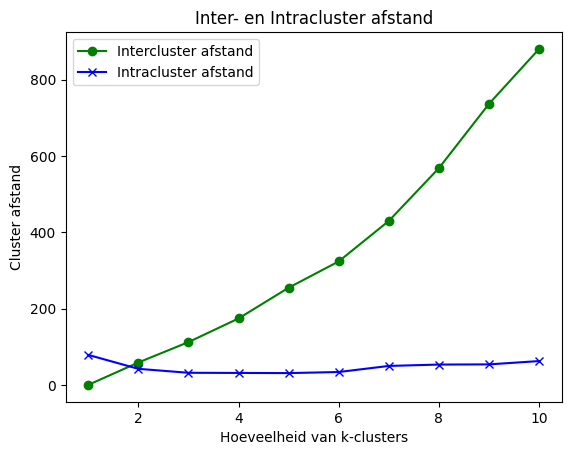

In [104]:
intercluster_distances: list = []
intracluster_distances: list = []
k_options = range(1, 11)

for k in k_options:
    kmeans: KMeans = KMeans(n_clusters=k, random_state=42)
    df["Centrum"] = kmeans.fit_predict(df)
    kmeans_center = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)
    
    intercluster_distance: Literal[0] = 0
    intracluster_distance: Literal[0] = 0

    common_columns: Any = df.columns.intersection(kmeans_center.columns)

    for centrumindex, _ in kmeans_center[common_columns].iterrows():
        for src_index, _ in df[common_columns].iterrows():
            if df.at[src_index, "Centrum"] == centrumindex:
                diff = df.loc[src_index, common_columns] - kmeans_center.loc[centrumindex, common_columns]
                distance = np.linalg.norm(diff[pd.to_numeric(diff, errors="coerce").notnull()])
                intracluster_distance += distance
            else:
                diff = df.loc[src_index, common_columns] - kmeans_center.loc[centrumindex, common_columns]
                distance = np.linalg.norm(diff[pd.to_numeric(diff, errors="coerce").notnull()])
                intercluster_distance += distance

    intercluster_distances.append(intercluster_distance)
    intracluster_distances.append(intracluster_distance)

plt.plot(k_options, intercluster_distances, marker="o", label="Intercluster afstand", color="g")
plt.plot(k_options, intracluster_distances, marker="x", label="Intracluster afstand", color="b")
plt.xlabel("Hoeveelheid van k-clusters")
plt.ylabel("Cluster afstand")
plt.title("Inter- en Intracluster afstand")
plt.legend()
plt.show()